In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.stats import poisson
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm

In [2]:
catnat = pd.read_csv("./catnat_gaspar.csv", sep=";", dtype={"cod_commune":str}, parse_dates=['dat_deb','dat_fin','dat_pub_arrete','dat_pub_jo'])
fonc = pd.read_csv("./valeursfoncieres-2022.txt", sep="|", dtype={"Code departement": str,"Code commune":str}, parse_dates=["Date mutation"])

C:\Users\xiaji\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (23,24,26,28,29,31,33,41) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
catnat.head()


,cod_nat_catnat,cod_commune,lib_commune,num_risque_jo,lib_risque_jo,dat_deb,dat_fin,dat_pub_arrete,dat_pub_jo,dat_maj
0,BUDD8750068A,52197,Fayl-Billot,54.0,Inondations et/ou Coulées de Boue,1987-07-07,1987-07-08,1987-09-27,1987-10-09,2022-05-20 15:53:47.746
1,BUDD8750068A,54013,Amenoncourt,54.0,Inondations et/ou Coulées de Boue,1987-07-07,1987-07-08,1987-09-27,1987-10-09,2022-05-20 15:53:47.746
2,BUDD8750068A,54299,Laneuveville-devant-Bayon,54.0,Inondations et/ou Coulées de Boue,1987-07-07,1987-07-08,1987-09-27,1987-10-09,2022-05-20 15:53:47.746
3,BUDD8750068A,54528,Toul,54.0,Inondations et/ou Coulées de Boue,1987-07-07,1987-07-08,1987-09-27,1987-10-09,2022-05-20 15:53:47.746
4,BUDD8750068A,67340,Oberbronn,54.0,Inondations et/ou Coulées de Boue,1987-07-01,1987-07-01,1987-09-27,1987-10-09,2022-05-20 15:53:47.726


In [4]:
fonc.head()

,Identifiant de document,Reference document,1 Articles CGI,2 Articles CGI,3 Articles CGI,4 Articles CGI,5 Articles CGI,No disposition,Date mutation,Nature mutation,...,Surface Carrez du 5eme lot,Nombre de lots,Code type local,Type local,Identifiant local,Surface reelle bati,Nombre pieces principales,Nature culture,Nature culture speciale,Surface terrain
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2022-03-01,Vente,...,NaN,1,2.0,Appartement,NaN,24.0,1.0,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2022-03-01,Vente,...,NaN,0,NaN,NaN,NaN,NaN,NaN,S,NaN,84.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2022-03-01,Vente,...,NaN,0,NaN,NaN,NaN,NaN,NaN,S,NaN,88.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2022-03-01,Vente,...,NaN,1,2.0,Appartement,NaN,140.0,3.0,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2022-04-01,Vente,...,NaN,0,NaN,NaN,NaN,NaN,NaN,T,NaN,510.0


In [5]:
catnat["Code region"] = catnat["cod_commune"].str[:2]
catnat = catnat[["lib_risque_jo", "dat_deb", "Code region"]]
fonc = fonc[fonc['Type local'].isin(['Appartement', 'Maison'])]
fonc.loc[fonc["Code commune"].str.len() < 3, "Code commune"] = fonc["Code commune"].str.zfill(3)
fonc["Code region"] = fonc["Code departement"]
fonc = fonc[["Valeur fonciere", "Code region"]]

In [6]:
catnat.head()

,lib_risque_jo,dat_deb,Code region
0,Inondations et/ou Coulées de Boue,1987-07-07,52
1,Inondations et/ou Coulées de Boue,1987-07-07,54
2,Inondations et/ou Coulées de Boue,1987-07-07,54
3,Inondations et/ou Coulées de Boue,1987-07-07,54
4,Inondations et/ou Coulées de Boue,1987-07-01,67


In [7]:
fonc.head()

,Valeur fonciere,Code region
0,"55000,00",01
3,"143000,00",01
5,"255000,00",01
8,"525000,00",01
12,"64000,00",01


In [8]:
# liste des types de catastrophes naturelles
occurrences = catnat.groupby(['lib_risque_jo']).size().reset_index(name='occurrences')

In [9]:
occurrences

,lib_risque_jo,occurrences
0,Avalanche,131
1,Choc M�caniques li�s � l'action des Vagues,1
2,Chocs Mécaniques liés à l'action des Vagues,6761
3,Chocs M�caniques li�s � l'action des Vagues,1
4,Coulée de Boue,6
5,Divers,65
6,Eboulement et/ou Chute de Blocs,70
7,Effondrement et/ou Affaisement,122
8,Eruption Volcanique,1
9,Glissement de Terrain,3903


In [10]:
catnat['lib_risque_jo'] = catnat['lib_risque_jo'].replace({
    'Avalanche': 'montagne',
    "Choc M�caniques li�s � l'action des Vagues": 'ocean',
    "Chocs Mécaniques liés à l'action des Vagues": 'ocean',
    "Chocs M�caniques li�s � l'action des Vagues": 'ocean',
    "Inondations par choc mécanique des vagues": 'ocean',
    'Coulée de Boue': 'montagne',
    "Divers": "divers",
    "Eboulement et/ou Chute de Blocs": 'montagne',
    "Effondrement et/ou Affaisement": "terrain" ,
    "Eruption Volcanique" : "divers",
    "Glissement de Terrain": "terrain" ,
    "Glissement et Eboulement Rocheux": 'montagne',
    "Glissement et Effondrement de Terrain": 'terrain',
    "Grêle": "meteo",
    "Inondations Remontée Nappe": "inondation",
    "Inondations et/ou Coulées de Boue": "inondation",
    "Inondations et/ou Coul�es de Boue": "inondation",
    "Lave Torrentielle": "divers",
    "Mouvement de Terrain": 'terrain',
    'Mouvements de terrains (hors sécheresse géotechnique)': 'terrain',
    "Mouvements de terrain différentiels consécutifs à la sécheresse et à la réhydratation des sols": 'terrain',
    "Poids de la Neige": "meteo",
    "Raz de Marée": 'ocean',
    "Secousse Sismique": "terrain" ,
    "Séismes": "terrain",
    "Sécheresse": "meteo",
    "S�cheresse": "meteo",
    "Tempête": "meteo",
    "Vents Cycloniques": "meteo",
})

In [11]:
occurrences = catnat.groupby(['lib_risque_jo']).size().reset_index(name='occurrences')

In [12]:
occurrences

,lib_risque_jo,occurrences
0,divers,73
1,inondation,142788
2,meteo,65570
3,montagne,208
4,ocean,6777
5,terrain,38575


In [13]:
damage_coefficients = [0.05,0.1,0.2,0.3,0.5,0.8]
position = {
    'meteo': 0,
    'inondation': 1,
    'terrain': 2,
    'montagne': 3,
    "ocean": 4,
    'divers': 5,  
}
param = [1.1, 1.2, 1.5, 0.9]

In [14]:
n_type = 6
regions = list(fonc['Code region'].unique())+["57", "67", "68", "97"]
n_region = len(regions)
regions = np.array(regions)
print(regions)
print(np.where(regions=="57")[0][0])

['01' '02' '03' '04' '05' '06' '07' '08' '09' '10' '11' '12' '13' '14'
 '15' '16' '17' '18' '19' '21' '22' '23' '24' '25' '26' '27' '28' '29'
 '2A' '2B' '30' '31' '32' '33' '34' '35' '36' '37' '38' '39' '40' '41'
 '42' '43' '44' '45' '46' '47' '48' '49' '50' '51' '52' '53' '54' '55'
 '56' '58' '59' '60' '61' '62' '63' '64' '65' '66' '69' '70' '71' '72'
 '73' '74' '76' '77' '78' '79' '80' '81' '82' '83' '84' '85' '86' '87'
 '88' '89' '90' '91' '92' '93' '94' '95' '971' '972' '973' '974' '75' '57'
 '67' '68' '97']
97


In [15]:
#mise en forme des donnée :

#cat-nat : un array de arrays, chaque array concerne un département et contient les dates d'occurence d'innondation en jour après la première date.
#valeur foncière : un array de arrays, chaque array contient un array de valeur foncière dans un département donné et la date de leur évaluation/transaction


In [16]:
deb = min(catnat['dat_deb'])
print(min(catnat['dat_deb']))

1982-08-15 00:00:00


In [17]:
def calculate_days_difference_1(date_list):
    return [(date - deb).days for date in date_list]
def relative_time(date):
    return (date - deb).days
# return une série temporel de matrice de catnat avec chaque ligne un type de catnat et chaque colonne une région
def get_catnat_serie(catnat):
    catnat['dat_deb'] = pd.to_datetime(catnat['dat_deb'])
    catnat['annee'] = catnat['dat_deb'].dt.year
    serie = []
    liste_dataframes = []
    groupes = catnat.groupby('annee')
    for annee, groupe in groupes:
        liste_dataframes.append(groupe)
    liste_dataframes = sorted(liste_dataframes, key=lambda x: x['annee'].iloc[0])
    n_annee = len(liste_dataframes)
    for a in range(n_annee):
        M = np.zeros((n_type, n_region), dtype = int)
        grouped_by_type = [group for _, group in liste_dataframes[a].groupby(["lib_risque_jo"])]
        for i in range(len(grouped_by_type)):
            pos = int(position[grouped_by_type[i].iloc[0]["lib_risque_jo"]])
            grouped_by_type[i] = grouped_by_type[i].groupby("Code region")['dat_deb'].agg(list).reset_index()
            for j in range(grouped_by_type[i].shape[0]):
                #print(str(grouped_by_type[i].iloc[j]["Code region"]))
                region_p = np.where(regions==str(grouped_by_type[i].iloc[j]["Code region"]))[0][0]
                M[pos][region_p] = int(len(grouped_by_type[i].iloc[j]["dat_deb"]))
        serie.append(M)
    return(serie)

        
    

In [18]:
def preprocess1(catnat): 
    grouped_by_type = [group for _, group in catnat.groupby(["lib_risque_jo"])]
    for k in range(len(grouped_by_type)):
        date_debut = min(grouped_by_type[k]['dat_deb'])
        #grouped_by_type[k] = grouped_by_type[k].groupby([param, 'dat_deb']).size().reset_index(name='occurrences')
        grouped_by_type[k]['dat_deb'] = grouped_by_type[k]['dat_deb'].apply(relative_time)
        cat_nat_type = grouped_by_type[k].iloc[0]["lib_risque_jo"]
        grouped_by_type[k] = grouped_by_type[k].groupby("Code region")['dat_deb'].agg(list).reset_index()
        grouped_by_type[k]['type'] = cat_nat_type
        grouped_by_type[k] = grouped_by_type[k][["Code region","type",'dat_deb']]
    return grouped_by_type[1:]
    
def preprocess2(fonc):
    #fonc['Date mutation'] = pd.to_datetime(fonc['Date mutation'], format='%d/%m/%Y')
    #fonc = fonc.drop_duplicates(subset='Date mutation')
    fonc_by_type = [group for _, group in fonc.groupby("Code region")]
    for k in range(len(fonc_by_type)):
        #date_debut = min(fonc_by_type[k]['Date mutation'])
        #fonc_by_type[k]['days_difference'] = fonc_by_type[k]['Date mutation'].apply(relative_time)
        fonc_by_type[k]['Valeur fonciere'] = pd.to_numeric(fonc_by_type[k]['Valeur fonciere'].str[0:-3], errors='coerce').astype(float)
        #df2['days_difference'] = df2['Date mutation'].transform(lambda x: (x - date_debut_2).dt.days)  #prend trop de temps à s'exécuter!!
        fonc_by_type[k] = fonc_by_type[k][["Code region", 'Valeur fonciere']]
    return fonc_by_type



In [19]:
def process(catnat, fonc, duration, cat_coef):
    M = len(catnat)
    N = 35
    cost = np.zeros((M,N))
    for k in range(M):
        coef = damage_coefficients[str(catnat[k].iloc[0]["type"])]
        for i in range(N):
            print(fonc[i]["Valeur fonciere"].mean())
            cost[k][i] = coef*len(catnat[k].iloc[0]["dat_deb"])*fonc[i]["Valeur fonciere"].mean()/10**9
    m = 0
    for i in range(duration):
        m += (1+cat_coef)**i
    return(m*cost, np.sum(cost))
        


In [20]:
def compute_historical_cost(serie, fonc):
    cost = []
    total_cost = []
    vague = 0
    prices = []
    for j in range(len(fonc)):
        vague += fonc[j]["Valeur fonciere"].mean()
        prices.append(fonc[j]["Valeur fonciere"].mean)
    vague /= len(fonc)
    prices += [vague*param[0], vague*param[1], vague*param[2], vague*param[3]]
    for m in serie:
        M = np.zeros((n_type, n_region))
        for i in range(n_type):
            for j in range(n_region):
                if j >=97:
                    value = vague
                else:
                    value = fonc[j]["Valeur fonciere"].mean()
                M[i][j] = m[i][j]*damage_coefficients[i]*value/10**9
        cost.append(M)
        total_cost.append(M.sum())
    return(cost, total_cost)

In [21]:
df1, df2 = preprocess1(catnat), preprocess2(fonc)

In [22]:
#données catnat depuis 1982-08-15

In [23]:
df1[2]

,Code region,type,dat_deb
0,02,montagne,[4522]
1,04,montagne,[9681]
2,05,montagne,"[9621, 11172, 9618, 4163, 9620, 4871, 9618, 14..."
3,06,montagne,"[4162, 4162, 5162, 9620, 1265, 5241, 5249, 962..."
4,09,montagne,"[4539, 11486, 11484, 11485, 4647, 11156]"
5,12,montagne,[5643]
6,13,montagne,[5261]
7,14,montagne,[4867]
8,24,montagne,[4352]
9,26,montagne,"[9701, 5241]"


In [24]:
df2[0]

,Code region,Valeur fonciere
0,01,55000.0
3,01,143000.0
5,01,255000.0
8,01,525000.0
12,01,64000.0
...,...,...
50776,01,26000.0
50781,01,46000.0
50784,01,47000.0
50789,01,25100.0


In [25]:
# cost = la matrice représentant les coûts anticipés par catastrophe (lignes) par département (colonnes) en Milliards
#total_cost = coût total


In [26]:
#cost, total_cost = process(df1, df2, 5, 0.2)

In [27]:

#occurrences = occurrences de chaque type de sinistres
occurrences 

,lib_risque_jo,occurrences
0,divers,73
1,inondation,142788
2,meteo,65570
3,montagne,208
4,ocean,6777
5,terrain,38575


In [28]:
#simulation : 
#simuler l'arrivé global des catastrophes, tirage aléatoire pour savoir le type de catastrophe, le département, le nombre de prop touché, n propriétés.

In [29]:


# List of arrival times
arrival_times = [1, 1, 2, 3, 6, 6, 6, 5, 7]

# Step 1: Remove duplicates


# Step 2: Count occurrences of each unique element


# Step 3: Estimate lambda for a Poisson distribution
#lambda_estimate = np.mean(counts)

# Print results
#print("Unique Arrival Times:", unique_arrival_times)
#print("Counts of Each Element:", counts)
#print("Estimated Lambda:", lambda_estimate)

def estimate_lbd(arrival_times): # Pour un type de sinistre et dans une certaine région
    unique_arrival_times = list(set(arrival_times))
    counts = [arrival_times.count(time) for time in unique_arrival_times]
    if len(unique_arrival_times)<=2:
        return sum(counts), counts
    inter_arrival_times = np.diff(np.array(unique_arrival_times))
    mean_inter_arrival_time = np.mean(inter_arrival_times)
    lambda_estimate = 1 / mean_inter_arrival_time
    return lambda_estimate, counts
def simulate(duration, cat_coef, cat_type, lambdas, N, prices):
    cost  = 0
    for i in range(M):
        for j in range(N):
            #draw
            damage_rate = damage_coefficients[i]
            #draw region
            lbd, counts = lambdas[i][j], N[i][j]
            if lbd <=0:
                n_disaster = -lbd + 1
            else:
                n_disaster = np.random.choice(counts, size=np.random.poisson(lbd), replace=True).sum()
            cost += damage_rate*np.random.choice(prices, size=n_disaster, replace=True).sum()
    return(cost)

In [30]:
serie = get_catnat_serie(catnat)


In [31]:
print(serie[7])

[[  6   2  45  14   0   4   3   0  18  21  27   0  47   3   1  34 150  96
    2   0   0   0 440   0   5   5  37   0   0   0   8 374 427 195  11   2
  128  43   0   2  44 113   1   0  23 159 124 263   0  58   0   0   0   0
   25   0   0  12 104   1   5  78  65  74  67   3   1   0   0  76   0   0
    0 134 109  78   2  55 162  32   9  54 102   0   0  11   0  62  10  26
   31  44   0   0   0   0   0  11   0   0   0]
 [  1   2   3   4   0   3  51   0   0   0  12   5   7   1   0   0   0   0
    0   6  10   0  18   1   0   2   3  15   3  43   0  21  10  16  10   2
    0   0   0   0  15   6   0   0   6   0  41   4   0   5   0   1   3   0
    9   0   1   0  19   0   3   0   0  15   2  47  25   5  18   1   1   1
    8   1   6   0   0   0   1   2   0   2   0   0   6   2   0   0   0   1
    0   0   0   0   0   0   0  10   2  56   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   1   0   0   0   0
    0   0   0   0 

In [32]:
historical_cost, total_historical_cost = compute_historical_cost(serie, df2)
# historical_cost : série temporel de matrices de coûts avec chaque ligne un type de catnat et chaque colonne une région

In [33]:
print(total_historical_cost) # Pertes historiques agrégées par année

[0.884671638553186, 1.157843950457952, 0.1214042029855274, 0.03798978309040117, 0.4392319665933006, 2.106024235664407, 1.338695095001124, 0.136976053473014, 0.3354765165792348, 0.08807385645491984, 0.22811236617079006, 1.0558108505531416, 0.28083324938865, 2.8992806422013775, 0.22594635687260917, 0.26530619176447195, 0.10651757008942166, 18.782226231544495, 1.1996867173384413, 1.8359691803130516, 0.15868580596773882, 0.21710656945209228, 0.06706973841046274, 0.15450774901026315, 0.08348589761414915, 0.17058361481147333, 2.6521268090210706, 0.6283678180580655, 1.3977691613480752, 0.33356059952615136, 0.06393025984791932, 1.6394461260468942, 2.7163944478092046, 0.10067727835304634, 0.1669861597569686, 0.14077107174808212, 0.4758577051431265, 0.20542534078581864, 0.31394254601244065, 0.20645021725863755, 0.24510313004821951, 0.05483790490551915]


Random walk with drift model <br>
$y_t = \beta_0 + \beta_1 * y_{t-1} + \epsilon_t$ where $\beta_0$ the general trend, $y_{t-1}$ the value at time t-1 and $epsilon_t$ a normal process with mean 0 and variance 1 

In [34]:
def estimate(data):
    y = data.copy()
    y_lag = np.roll(y, 1) #y_t-1
    y_lag[0] = 0
    X = sm.add_constant(y_lag)
    model = sm.OLS(y, X)
    results = model.fit()
    beta_0 = results.params[0]
    beta_1 = results.params[1]
    return beta_0,beta_1,results.resid
def VaR(data, time_horizon,confidence_level):
    beta_0, beta_1,residuals = estimate(data)
    volatility = np.std(residuals)
    z_critical = norm.ppf(confidence_level)
    aux = (1 - beta_1**(2*(time_horizon+1)))/(1-beta_1**2)
    var = data[-1]*(beta_1**time_horizon) + beta_0 * (1-beta_1**(time_horizon+1))/(1-beta_1) + z_critical * volatility * np.sqrt(aux)
    return var
def projection(data, time_horizon):
    beta_0, beta_1,_ = estimate(data)
    project = []
    epsilon = np.random.normal(size=time_horizon)
    project.append(beta_0 + beta_1 * data[-1] + epsilon[0])
    for i in range(1,time_horizon):
        project.append(beta_0 + beta_1 * project[i-1] + epsilon[i])
    return project
def display(data,time_horizon, confidence_level, climate_change_coef):
    data = np.cumsum(data)
    time = np.arange(0, 0+len(data)+time_horizon,1)
    var = VaR(data, time_horizon, confidence_level)
    total_mult = 1
    #plt.plot(data, label='cumulative historical cost')
    #plt.plot(np.diff(np.insert(data, 0, 0)), label='historical cost')
    data_predict = projection(data,time_horizon)
    for k in range(time_horizon):
        data_predict[k] *= climate_change_coef**k
        total_mult += (2-confidence_level)**(k+1)*(climate_change_coef**(k+1)-1)/1.96
    total_future_loss = data_predict[-1]-data[-1]
    total_var = (var-data[-1])*total_mult+max(data)/len(data)/1.96*confidence_level*time_horizon
    par_annee = np.diff(np.insert(np.concatenate((data,data_predict)),0,0))
    plt.plot(time, par_annee, color='green', label='par annee')
    plt.plot(time, np.concatenate((data,data_predict)), color='yellow', label='cummulé')
    plt.plot(time, np.concatenate((data,data_predict))-data[-1], color='black', label='cummulé à partir de 2022')
    plt.axhline(total_var, color='red', linestyle='--', label='VaR')
    plt.axvline(len(data), color='blue', linestyle='--', label='Présent')
    plt.xlabel('Time')
    plt.ylabel('y')
    plt.legend()
    plt.show()
    
    
    return(data_predict,par_annee[-time_horizon:], total_future_loss, total_var)

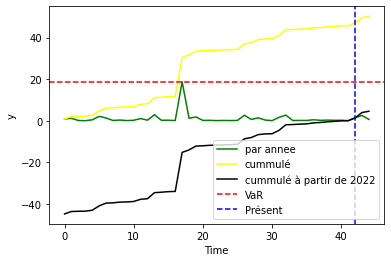

In [35]:
horizon = 3
disaster coef = 1.02

data_predict, par_annee, total_future_loss, total_var = display(total_historical_cost, horizon, 0.99 ,disaster coef)

In [36]:
print(data_predict) #prédiction des pertes cumulé (en Milliards)
print(par_annee) #prédiction des pertes par annee
print(total_future_loss) # pertes futures prédites
print(total_var) # VaR total sur l'horizon

[47.08662957866629, 49.65812508235213, 50.29592962234021]
[1.36746697 2.5714955  0.63780454]
4.576767016315287
18.712511783439897


In [37]:
def decoupage(historical_cost, par_annee, horizon, cata):
    pred = np.zeros((n_type, n_region))
    M = np.zeros((n_type, n_region))
    for k in range(len(historical_cost)):
        M +=historical_cost[k]/np.mean(historical_cost[k])
    M = M/len(historical_cost)
    for k in range(horizon):
        pred += M*cata**k*par_annee[k]
    for i in range(pred.shape[0]):
        for j in range(pred.shape[1]):
            pred[i][j] = (pred[i][j]*1000)//1/1000
    return(pred)

In [38]:
pred = decoupage(historical_cost, par_annee, time_horizon, catastrophe)

In [39]:
print(pred)

[[1.55100e+00 1.71000e-01 1.85700e+00 9.65000e-01 3.02000e-01 5.04200e+00
  1.32000e+00 1.44000e-01 1.59800e+00 4.85000e-01 4.09100e+00 4.23000e-01
  1.76150e+01 5.54000e-01 1.89000e-01 1.58000e+00 9.79400e+00 2.02300e+00
  5.27000e-01 2.02300e+00 9.55700e+00 1.75000e-01 7.89300e+00 9.41000e-01
  1.30200e+00 4.06000e-01 5.95000e-01 2.45000e-01 1.60000e-02 2.90000e-02
  4.04100e+00 2.58370e+01 9.77900e+00 2.96550e+01 3.55500e+00 3.15000e-01
  2.27400e+00 3.36500e+00 8.82000e-01 1.79900e+00 1.25500e+00 2.12300e+00
  1.36300e+00 5.01000e-01 5.56000e-01 3.35000e+00 1.63200e+00 7.19400e+00
  1.04000e-01 2.95200e+00 2.61000e-01 4.70000e-01 4.84000e-01 2.30000e-02
  6.48200e+00 3.21000e-01 9.10760e+01 8.64000e-01 5.13800e+00 4.52000e-01
  1.71000e-01 2.09300e+00 2.75900e+00 3.55200e+00 2.91000e+00 7.58000e-01
  2.65800e+00 4.26000e-01 3.16500e+00 1.76900e+00 5.98000e-01 8.55000e-01
  8.63000e-01 3.71500e+00 4.60400e+00 1.13490e+01 5.00000e-02 6.22400e+00
  5.80400e+00 2.50500e+00 5.15000e+00 